# Laplace approximations

This example requires pytorch and the laplace-torch package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from laplace import Laplace
from laplace.curvature.backpack import BackPackGGN
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

%load_ext watermark

### Generate data

In [2]:
def test_function(x):
    return np.sin(2.0 * x) + np.cos(x)


n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = test_function(X) + noise
y_test = test_function(X_test) + noise_test

scaler = StandardScaler()
X_ = scaler.fit_transform(X)
X_test_ = scaler.transform(X_test)

X_, y = torch.tensor(X_, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
X_test_, y_test = (
    torch.tensor(X_test_, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32),
)

### Define a simple MLP

In [3]:
def build_mlp():
    return nn.Sequential(
        nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 50), nn.Tanh(), nn.Linear(50, 1)
    )

### Post-hoc Laplace

#### Train the network

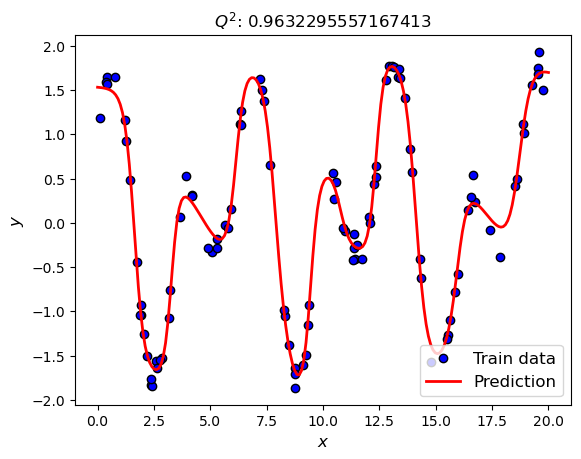

In [4]:
model = build_mlp()

train_loader = DataLoader(
    dataset=TensorDataset(X_, y), batch_size=32, shuffle=True, drop_last=True
)

optimizer = optim.AdamW(model.parameters(), lr=5e-3)
loss_fn = nn.MSELoss()

for epoch in range(1_000):
    for ib, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(y_batch, pred)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred_test = model(X_test_).detach().cpu().numpy()

plt.figure()
plt.plot(
    X,
    y,
    ls="",
    marker="o",
    markerfacecolor="b",
    markeredgecolor="k",
    markeredgewidth=1,
    label="Train data",
)
plt.plot(X_test, y_pred_test, color="r", lw=2, label="Prediction")
plt.legend(fontsize=12)
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$y$", fontsize=12)
out = plt.title(rf"$Q^2$: {r2_score(y_test, y_pred_test)}")

#### Fit Laplace approximation

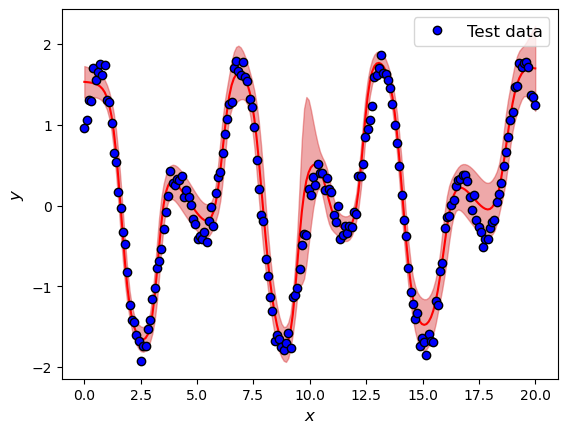

In [5]:
hessian_structure = "kron"
sigma_noise = 0.1
prior_precision = 1.0

la = Laplace(
    model=model,
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian_structure,
    sigma_noise=sigma_noise,
    prior_precision=prior_precision,
    backend=BackPackGGN,
)
la.fit(train_loader)

f_mu, f_var = la(X_test_)
f_mu, f_var = f_mu.squeeze(), f_var.squeeze()

plt.figure()
plt.plot(X_test, f_mu, color="r")
plt.plot(
    X_test,
    y_test,
    ls="",
    marker="o",
    markerfacecolor="b",
    markeredgecolor="k",
    markeredgewidth=1,
    label="Test data",
)
out = plt.fill_between(
    X_test.squeeze(),
    f_mu - 1.96 * np.sqrt(f_var),
    f_mu + 1.96 * np.sqrt(f_var),
    color="tab:red",
    alpha=0.4,
)
plt.legend(fontsize=12)
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$y$", fontsize=12)
plt.legend(fontsize=12)

In [6]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Wed Mar 13 2024

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

torch     : 2.2.1
matplotlib: 3.8.3
numpy     : 1.26.4

Watermark: 2.4.3

